In [23]:
import requests
from bs4 import BeautifulSoup
import re

import numpy as np
import string
import nltk
from nltk.corpus import stopwords


from nltk.stem import PorterStemmer
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer


#from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer #to lemmatize french wor
import gensim
from gensim import corpora
from gensim.models import phrases, Phrases, coherencemodel

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix,f1_score,mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier


import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from wordcloud import *

In [2]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [37]:
import spacy

KeyboardInterrupt: 

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv("air_canada_reviews.csv").drop(columns='Unnamed: 0') #08 november
df.loc[df.Notes == int(0),'Notes']=1.0

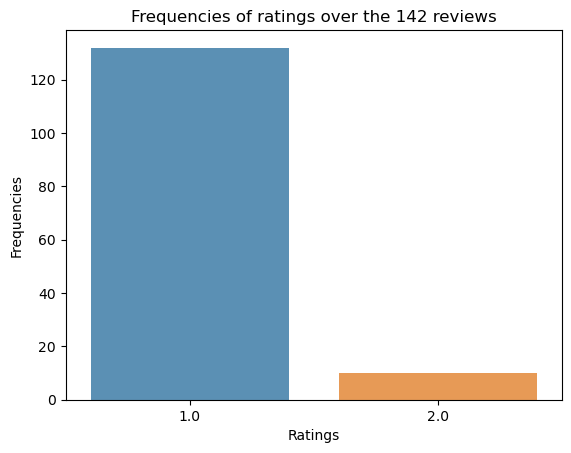

In [5]:
# Show frequencies of ratings with  barplot
X_ratings = df.Notes.value_counts()
ax = sns.barplot(x=X_ratings.index,y=X_ratings,alpha=0.8)
ax.set(xlabel='Ratings',ylabel='Frequencies',title='Frequencies of ratings over the {} reviews'.format(df.shape[0]))
plt.show()

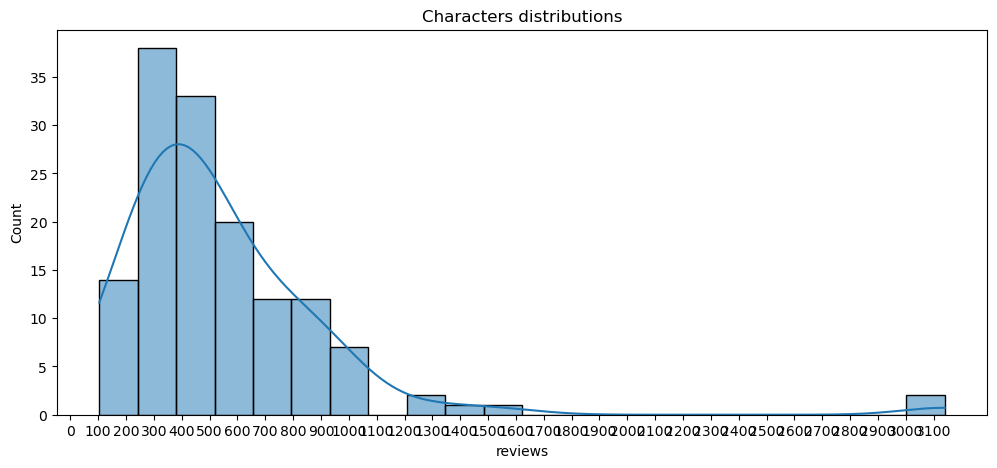

In [6]:
# Show number of characters in comments using histogram with kernel density estimate
len_contents = df['reviews'].apply(lambda x:len(str(x)))
ax = plt.figure(figsize=(12,5))
sns.histplot(len_contents, kde=True)
plt.title('Characters distributions')
plt.xticks(range(0,max(len_contents),100))
plt.show()

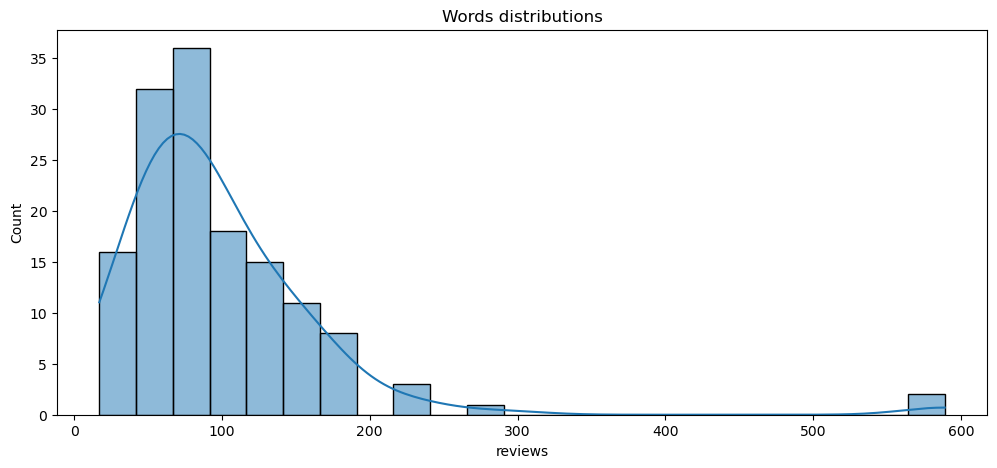

In [7]:
# Show number of words in each comments using histogram with kernel density estimate
len_contents_w = df['reviews'].apply(lambda x:len(str(x).split(" ")))
ax = plt.figure(figsize=(12,5))
sns.histplot(len_contents_w, kde=True)
plt.title('Words distributions')
plt.show()

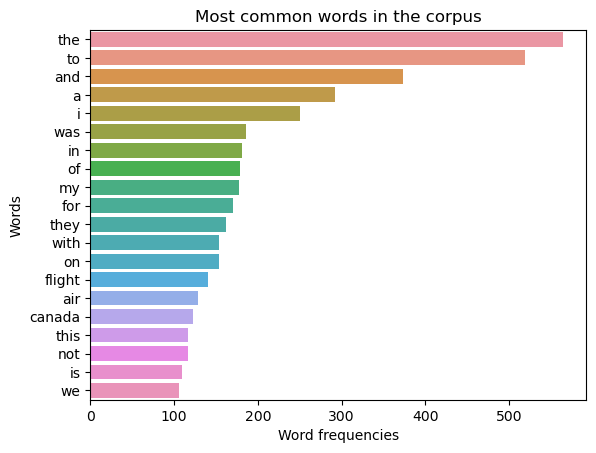

In [8]:
# Compute frequencies of words in the corpus
allWords = np.concatenate(df['reviews'].str.lower().str.split().values, axis = 0)
dist = nltk.FreqDist(allWords) # Get the frequency of words
# Plot distribution for the 20 first common words
y, X = [nb[0] for nb in dist.most_common(20)] ,[nb[1] for nb in dist.most_common(20)]
ax = sns.barplot(x=X,y=y)
ax.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the corpus')
plt.show()

## Préprocessing

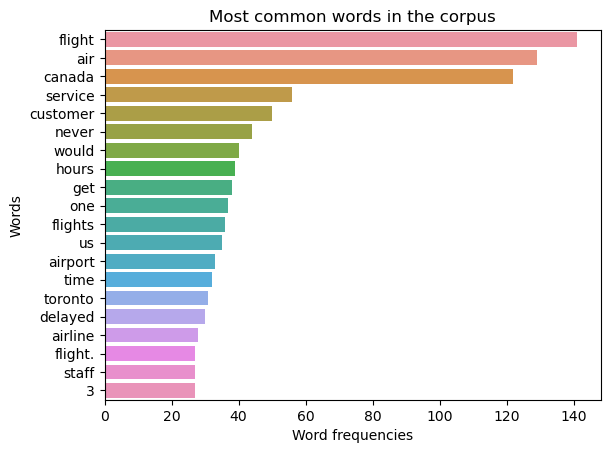

In [9]:
stopW = stopwords.words('english')
# Get all words that are not in the stopwords list
allWords2 = [e for e in allWords if e not in stopW]
# Get distribution of the previous list and plot it for the 20 first common words
dist = nltk.FreqDist(allWords2)
y, X = [nb[0] for nb in dist.most_common(20)] ,[nb[1] for nb in dist.most_common(20)]
ax = sns.barplot(x=X,y=y)
ax.set(xlabel='Word frequencies',ylabel='Words',title='Most common words in the corpus')
plt.show()

In [53]:
more_stopwords =  ['a','company', 'air', 'airline', 'canada', 'airport', 'travel', 'get', 'flight', 'fly', 'n\'t', 'also', "quite", '...']
# List of punctuation to remove
exclude = set(string.punctuation)


lemma = WordNetLemmatizer()


# Build a function to apply all transformation on a sentence
def preprocessing(sent,**args):
    tokens = word_tokenize(sent) # get word token (split sentence into a list of words)
    tokens = [w.lower() for w in tokens] # lower case
    tokens = [w for w in tokens if w not in stopW] # remove stop words
    tokens = [w for w in tokens if len(w)>2] # remove word with length < 2
    tokens = [lemma.lemmatize(lemma.lemmatize(lemma.lemmatize(w,pos='a'), pos = 'v'), pos='n') for w in tokens] # Lemmatize(pos is for adjective, verbs, nouns)
    tokens = [w for w in tokens if w not in exclude] # remove punctuation
    tokens = [w for w in tokens if w not in more_stopwords] # remove specific words
    return tokens

df['tokens'] = df['reviews'].apply(lambda x:preprocessing(x))

In [54]:
# Get a list of all tokens
allTokens = df['tokens'].tolist()
# Compute bigram model
bigram =  Phrases(allTokens, min_count = 10)
# Freeze the model and export minimal functionnality to be faster
bigram_mod = phrases.Phraser(bigram)
# Apply to all tokens
df['tokens_bigram'] = df['tokens'].apply(lambda x: bigram_mod[x])
# All tokens list
allBigramTokens = df['tokens_bigram'].tolist()


In [55]:
df.tokens_bigram

0      [terrible, experience, maple, lounge, refuse, ...
1      [delay, 12hours, toronto, heathrow, grind, sta...
2      [summary, third-world, run, bunch, people, ope...
3      [connect, delay, hour, stick, foreign, city, h...
4      [think, destination, wed, tandem, hire, agent,...
                             ...                        
137    [rouge, seat, close, would, stand, respect, cu...
138    [schedule, copenhagen, 4:30pm, tell, hour, ear...
139    [seriously, simply, thief, buy, round, trip, c...
140    [continue, fail, provide, level, human, servic...
141    [london, vancouver, london.wearing, mask, pain...
Name: tokens_bigram, Length: 142, dtype: object

In [56]:
# Show some Bigrams created
unique_words = list(set([word for sentence in allTokens for word in sentence]))
unique_words_bigram = list(set([word for sentence in allBigramTokens for word in sentence]))
list_new_bigram = [x for x in unique_words_bigram if x not in unique_words]
print(list_new_bigram[:10])

['customer_service', 'business_class']


In [57]:
text = ' '.join([' '.join(rev) for rev in df['tokens_bigram']])

C:\Users\matth\anaconda3\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


(-0.5, 4999.5, 2999.5, -0.5)

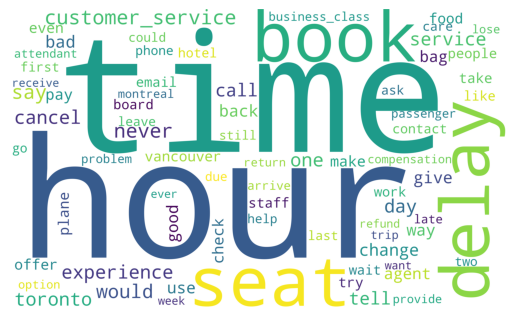

In [58]:
wordcloud = WordCloud(background_color = 'white', height=3000, width=5000, stopwords = stopW + more_stopwords , max_words = 75).generate(text)
plt.imshow(wordcloud)
plt.axis("off")

In [59]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=3, stop_words='english') # set the parameters for automatic selection of words
TermDocument = tfidf_vectorizer.fit_transform(df['tokens_bigram'].apply(lambda x : ' '.join(x))) # feed with your articles

In [60]:
n_dimensions = 3 # This can also be interpreted as topics in this case. This is the "beauty" of NMF. 5 is arbitrary
nmf = NMF(n_components=n_dimensions, random_state=41, l1_ratio=.5).fit(TermDocument)

In [61]:
# Analyze topics
words = tfidf_vectorizer.get_feature_names_out()
n_top_words = 10 # print 10 words by dimension. You can change this number

# Loop for each dimension: what words are the most dominant in each dimension
for i_dimension, dimension in enumerate(nmf.components_):
    print("Topic #%d:" % i_dimension)
    print(" ".join([words[i] for i in dimension.argsort()[:-n_top_words - 1:-1]]))
print()

Topic #0:
customer_service delay cancel hour use email day avoid book number
Topic #1:
seat say plane attendant economy mask way passenger montreal time
Topic #2:
bag check lose toronto baggage business_class hour heathrow day difficult



In [62]:
# Lits of tokens to use
tokens_for_lda = df["tokens_bigram"].values
# Use Doc2Bow to get weight for each tokens
dictionary = corpora.Dictionary(tokens_for_lda)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in tokens_for_lda]

In [63]:
%%time

# Build and fit LDA model 
number_of_topics = 4
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(
    doc_term_matrix,
    num_topics = number_of_topics, 
    id2word = dictionary,
    passes=4,
    random_state = 42,
    alpha = [0.1]*number_of_topics,
    eta = [0.01]*len(dictionary)
)

CPU times: total: 656 ms
Wall time: 729 ms


In [ ]:
ldamodel.save('../lda5.model')

In [64]:
pyLDAvis.enable_notebook()
reviews_vis = gensimvis.prepare(ldamodel, doc_term_matrix, dictionary)
viz = pyLDAvis.display(reviews_vis)

In [65]:
display(viz)

In [66]:
%%time

# Build and fit LDA model 
number_of_topics = 3
Lda = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda(
    doc_term_matrix,
    num_topics = number_of_topics, 
    id2word = dictionary,
    passes=4,
    random_state = 42,
    alpha = [0.1]*number_of_topics,
    eta = [0.01]*len(dictionary)
)
pyLDAvis.enable_notebook()
reviews_vis = gensimvis.prepare(ldamodel2, doc_term_matrix, dictionary)
viz = pyLDAvis.display(reviews_vis)
display(viz)

CPU times: total: 984 ms
Wall time: 1.23 s


In [67]:
pyLDAvis.show(reviews_vis)

OSError: [Errno 22] Invalid argument: 'https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.4.0/pyLDAvis/js/ldavis.v1.0.0.css'

In [66]:
# Show 'equations" of topics
topics = ldamodel.show_topics()
for i, el in topics:
    print('{} : \n{}\n'.format(i,el))
#Carefull, number assigned to a topic is different from real ldamodel to pyLDAvis

0 : 
0.011*"day" + 0.010*"time" + 0.009*"cancel" + 0.008*"staff" + 0.008*"seat" + 0.008*"service" + 0.007*"way" + 0.007*"say" + 0.007*"book" + 0.007*"experience"

1 : 
0.012*"hour" + 0.011*"delay" + 0.010*"customer_service" + 0.009*"time" + 0.008*"say" + 0.008*"book" + 0.008*"seat" + 0.008*"one" + 0.007*"tell" + 0.007*"give"

2 : 
0.019*"hour" + 0.014*"never" + 0.014*"delay" + 0.011*"seat" + 0.010*"book" + 0.010*"time" + 0.010*"use" + 0.010*"customer_service" + 0.009*"would" + 0.009*"bad"

